In [5]:
# Imports
import subprocess
import os
from joblib import Parallel, delayed
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [3]:
# Unpack zipped files for the defined protein
dir = "1a4g_na"
abbr = "na"
receptor = "1A4G"  # prefix of the receptor file
!gunzip $dir/$abbr-decoys.sdf.gz
!gunzip $dir/$abbr-ligands.sdf.gz

In [3]:
# Create pdbqt files of ligands (true and decoy) using obabel
!obabel $dir/$abbr-ligands.sdf -O $dir/$abbr-ligands.pdbqt
!obabel $dir/$abbr-decoys.sdf -O $dir/$abbr-decoys.pdbqt

40 molecules converted
1200 molecules converted


In [4]:
# Manually Splits a pdbqt file into the individual models and writes each model into an individual pdbqt file
def split_pdbqt(input_file, output_prefix):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    model = []
    model_count = 0
    inside_model = False

    for line in lines:
        if line.startswith("MODEL"):
            inside_model = True
            model = []
        elif line.startswith("ENDMDL"):
            inside_model = False
            # Write model to file
            output_file = f"{output_prefix}_{model_count:03d}.pdbqt"
            with open(output_file, "w") as out:
                out.writelines(model)
            model_count += 1
        elif inside_model:
            model.append(line)

    print(f"Saved {model_count} ligand files to {output_prefix}_*.pdbqt")


# Use the splitting function for the ligands and the decoys
def split_ligands_and_decoys(dir, abbr):
    output_dir_ligands = os.path.join(dir, "split_ligands")
    output_dir_decoys = os.path.join(dir, "split_decoys")
    os.makedirs(output_dir_ligands, exist_ok=True)
    os.makedirs(output_dir_decoys, exist_ok=True)

    input_ligands = os.path.join(dir, f"{abbr}-ligands.pdbqt")
    input_decoys = os.path.join(dir, f"{abbr}-decoys.pdbqt")

    split_pdbqt(input_ligands, os.path.join(output_dir_ligands, "ligand"))
    split_pdbqt(input_decoys, os.path.join(output_dir_decoys, "decoy"))


In [5]:
# Splitting of the ligand and decoy data
split_ligands_and_decoys(dir, abbr)

Saved 40 ligand files to 1a4g_na/split_ligands/ligand_*.pdbqt
Saved 1200 ligand files to 1a4g_na/split_decoys/decoy_*.pdbqt


In [7]:
output_dir_ligands = f"{dir}/split_ligands"
os.makedirs(output_dir_ligands, exist_ok=True)

output_dir_decoys = f"{dir}/split_decoys"
os.makedirs(output_dir_decoys, exist_ok=True)

In [12]:
# in Pymol we get the bounding box of the chosen ligand like this: get_extent ligand_ZMR
# This gives us the min values and max values for x, y, z, from these compute the box centers for docking
min = {'x': -7.638, 'y': 53.013, 'z': -12.316}
max = {'x': 1.912, 'y': 59.198, 'z': -4.813}

# calc box center and size
center_x = (min['x'] + max['x']) / 2
center_y = (min['y'] + max['y']) / 2
center_z = (min['z'] + max['z']) / 2

# calc box size
size_x = (max['x'] - min['x']) + 4
size_y = (max['y'] - min['y']) + 4
size_z = (max['z'] - min['z']) + 4

print("Center X: ", center_x, "Center Y: ", center_y, "Center Z: ", center_z)
print("Size X: ", size_x, "Size Y: ", size_y, "Size Z: ", size_z)

Center X:  -2.863 Center Y:  56.1055 Center Z:  -8.5645
Size X:  13.55 Size Y:  10.185000000000002 Size Z:  11.503


In [13]:
receptor_file = f"{dir}/{receptor}-receptor.pdbqt"
output_dir = f"{dir}/vs_results_ligands"
os.makedirs(output_dir, exist_ok=True)

ligands = sorted([f for f in os.listdir(output_dir_ligands) if f.endswith(".pdbqt")])

def dock(lig, input_path):
    try:
        lig_path = os.path.join(input_path, lig)
        out_path = os.path.join(output_dir, lig.replace(".pdbqt", "_docked.pdbqt"))
        
        if not os.path.isfile(lig_path):
            print(f"Ligand not found: {lig_path}")

        cmd = [
            "vina",
            "--receptor", receptor_file,
            "--ligand", lig_path,
            "--center_x", str(center_x),  # specify box center coordinates (float)
            "--center_y", str(center_y),
            "--center_z", str(center_z),
            "--size_x", str(size_x),
            "--size_y", str(size_y),
            "--size_z", str(size_z),
            "--exhaustiveness", "16",
            "--seed", "12345",
            "--out", out_path
        ]

        subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        print(f"Docked: {lig}")
        return f"success: {lig}"
    except subprocess.CalledProcessError as e:
        print(f"Docking failed: {lig}")
        return f"failed: {lig}"
    except Exception as e:
        print(f"Error for {lig}: {e}")
        return f"failed: {lig}"

# run in parallel for ligands
results = Parallel(n_jobs=os.cpu_count())(delayed(dock)(lig, output_dir_ligands) for lig in ligands)

Docked: ligand_001.pdbqt
Docked: ligand_003.pdbqt
Docked: ligand_002.pdbqt
Docked: ligand_005.pdbqt
Docked: ligand_004.pdbqt
Docked: ligand_007.pdbqt
Docked: ligand_000.pdbqt
Docked: ligand_012.pdbqt
Docked: ligand_010.pdbqt
Docked: ligand_008.pdbqt
Docked: ligand_014.pdbqt
Docked: ligand_011.pdbqt
Docked: ligand_006.pdbqt
Docked: ligand_013.pdbqt
Docked: ligand_017.pdbqt
Docked: ligand_018.pdbqt
Docked: ligand_009.pdbqt
Docked: ligand_023.pdbqt
Docked: ligand_024.pdbqt
Docked: ligand_020.pdbqt
Docked: ligand_025.pdbqt
Docked: ligand_015.pdbqt
Docked: ligand_029.pdbqt
Docked: ligand_027.pdbqt
Docked: ligand_019.pdbqt
Docked: ligand_022.pdbqt
Docked: ligand_031.pdbqt
Docked: ligand_021.pdbqt
Docked: ligand_032.pdbqt
Docked: ligand_033.pdbqt
Docked: ligand_030.pdbqt
Docked: ligand_034.pdbqt
Docked: ligand_016.pdbqt
Docked: ligand_037.pdbqt
Docked: ligand_038.pdbqt
Docked: ligand_035.pdbqt
Docked: ligand_039.pdbqt
Docked: ligand_036.pdbqt
Docked: ligand_028.pdbqt
Docked: ligand_026.pdbqt


In [14]:
# Do docking for all decoys
receptor_file = f"{dir}/{receptor}-receptor.pdbqt"
output_dir = f"{dir}/vs_results_decoys"
os.makedirs(output_dir, exist_ok=True)

ligands = sorted([f for f in os.listdir(output_dir_decoys) if f.endswith(".pdbqt")])

results = Parallel(n_jobs=os.cpu_count())(delayed(dock)(lig, output_dir_decoys) for lig in ligands)

Docked: decoy_002.pdbqt
Docked: decoy_004.pdbqt
Docked: decoy_003.pdbqt
Docked: decoy_000.pdbqt
Docked: decoy_007.pdbqt
Docked: decoy_006.pdbqt
Docked: decoy_001.pdbqt
Docked: decoy_005.pdbqt
Docked: decoy_008.pdbqt
Docked: decoy_009.pdbqt
Docked: decoy_013.pdbqt
Docked: decoy_014.pdbqt
Docked: decoy_010.pdbqt
Docked: decoy_011.pdbqt
Docked: decoy_012.pdbqt
Docked: decoy_016.pdbqt
Docked: decoy_015.pdbqt
Docked: decoy_017.pdbqt
Docked: decoy_020.pdbqt
Docked: decoy_023.pdbqt
Docked: decoy_018.pdbqt
Docked: decoy_022.pdbqt
Docked: decoy_019.pdbqt
Docked: decoy_021.pdbqt
Docked: decoy_025.pdbqt
Docked: decoy_024.pdbqt
Docked: decoy_027.pdbqt
Docked: decoy_029.pdbqt
Docked: decoy_026.pdbqt
Docked: decoy_031.pdbqt
Docked: decoy_028.pdbqt
Docked: decoy_032.pdbqt
Docked: decoy_030.pdbqt
Docked: decoy_034.pdbqt
Docked: decoy_033.pdbqt
Docked: decoy_037.pdbqt
Docked: decoy_036.pdbqt
Docked: decoy_035.pdbqt
Docked: decoy_038.pdbqt
Docked: decoy_040.pdbqt
Docked: decoy_039.pdbqt
Docked: decoy_04

In [15]:
# Function to extract the binding affinity of the energetically most favorable candidate from the vina_docked file
def extract_top_score(vina_pdbqt_path):
    with open(vina_pdbqt_path) as f:
        for line in f:
            if line.startswith('REMARK VINA RESULT:'):
                parts = line.strip().split()
                if len(parts) >= 4:
                    return float(parts[3])
        return None # if there is a problem (no score found)

In [16]:
# merge docking results (score) into one dataframe with label (ligand/decoy)
results_dir = f"{dir}/vs_results_ligands"
data = []

# store info of ligands
for file in os.listdir(results_dir):
    if file.endswith("_docked.pdbqt"):
        path = os.path.join(results_dir, file)
        score = extract_top_score(path)
        ligand_id = file.replace("_docked.pdbqt", "")
        data.append({"molecule": f"ligand_{ligand_id}", "score": score, "label": 1})

# store info of decoys
results_dir = f"{dir}/vs_results_decoys"

for file in os.listdir(results_dir):
    if file.endswith("_docked.pdbqt"):
        path = os.path.join(results_dir, file)
        score = extract_top_score(path)
        ligand_id = file.replace("_docked.pdbqt", "")
        data.append({"molecule": f"decoy_{ligand_id}", "score": score, "label": 0})

# store merged info
df = pd.DataFrame(data)

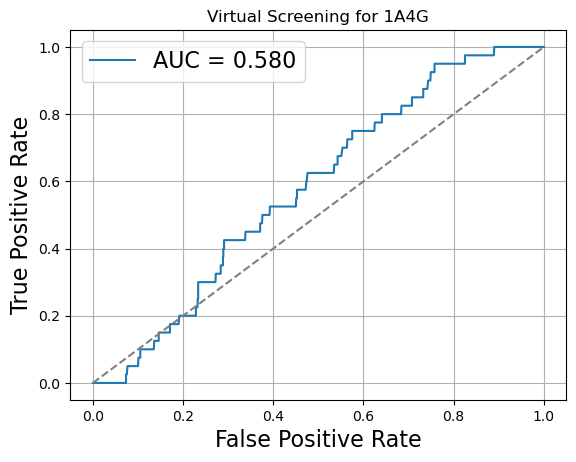

In [20]:
# calculate ROC and AUC
# invert score as negative scores are better
df["score_inv"] = -df["score"] 

#df['scaled_score'] = (df['score_inv'] - df['score_inv'].min()) / (df['score_inv'].max() - df['score_inv'].min())

# calculate fpr, tpr at varying thresholds
fpr, tpr, thresholds = roc_curve(df["label"], df["score_inv"])

# calculate auc 
auc = roc_auc_score(df["label"], df["score_inv"])

# plot ROC
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate", fontsize = 16)
plt.ylabel("True Positive Rate", fontsize = 16)
plt.legend(fontsize = 16)
plt.title(f"Virtual Screening for {receptor}")
plt.grid(True)
plt.savefig(f"{dir}/ROC.png")
plt.show()